# 5 Query, Result and Judgement Analysis

We're exploring the results from 66 different hybrid search configurations.

With a query set of 200+ queries and the judgements from the ESCI dataset we look at the impact of missing judgements on calculating search metrics.

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [48]:
df = pd.read_csv('results_and_ratings.csv', index_col=[0])

In [49]:
df.head(5)

,query_id,query_string,product_id,position,relevance,run,rating
0,0,$30 roblox gift card not digital,B00F4CF4PU,0,1.000000,min_maxarithmetic_mean0.0,NaN
1,0,$30 roblox gift card not digital,B07C438TMN,1,0.799684,min_maxarithmetic_mean0.0,NaN
2,0,$30 roblox gift card not digital,B00XJZHJCA,2,0.795128,min_maxarithmetic_mean0.0,NaN
3,0,$30 roblox gift card not digital,B00GAC1D2G,3,0.771049,min_maxarithmetic_mean0.0,NaN
4,0,$30 roblox gift card not digital,B004RMK4BC,4,0.742659,min_maxarithmetic_mean0.0,NaN


In [50]:
print(f"Total number of query-doc pairs: {df.shape[0]}")
print(f"Missing judgements: {df[df['rating'].isna()].shape[0]}")
print(f"Available judgements: {df[~df['rating'].isna()].shape[0]}")
print(f"Ratio of available judgements: {((df[~df['rating'].isna()].shape[0]/df.shape[0])*100)} %")

Total number of query-doc pairs: 1452000
Missing judgements: 1325865
Available judgements: 126135
Ratio of available judgements: 8.686983471074381 %


In [51]:
df_ratings = pd.read_csv('ratings.csv', sep="\t", names=['query', 'docid', 'rating', 'idx'])#, index=False)

# Make sure that the reference judgments are compatible
assert set(df.query_string.unique()) == set(df_ratings["query"].unique())

## Metrics

In [52]:
def dcg_at_10(df, k=10, position=None, **kwargs):
    # Sort by position and take the top k results
    # if position is given, the caller has already sorted the dataframe
    # an additional position argument is used to avoid excessive dataframe copying
    if position is None:
        df = df.sort_values('position')
        position = df["position"]
    if k:
        df = df.head(k)
        position = position[:10]

    # Apply DCG formula
    dcg = np.sum(2.0 ** (df['rating'] - 1) / np.log2(position + 2))
    
    return dcg


def ndcg_at_10(df, reference=None):
    # Calculate DCG@10
    dcg = dcg_at_10(df)
    
    # Use reference judgments, because best ratings may be outside of search results
    assert reference is not None

    # Reset the positional information - otherwise it uses the original positions and the 
    # changed sorting would have no effect
    ideal_top_10 = reference.sort_values("rating", ascending=False)
    position = np.arange(ideal_top_10.shape[0])
    
    # Calculate iDCG (ideal DCG)
    idcg = dcg_at_10(ideal_top_10, position=position, k=None)
    
    # Handle cases where iDCG is 0
    if idcg == 0:
        return 0
    
    # Normalize DCG
    ndcg = dcg / idcg
    
    return ndcg

def dg_at_10(df, k=10, **kwargs):
    """Failed attempt at performing a different aggregation for a DCG-like metric"""
    # Sort by position and take the top k results
    if k:
        df = df.sort_values('position').head(k)
    
    # Calculate DG for each result and average non-NaNs
    dgs = df['rating'] / np.log2(df['position'] + 2)
    dgs = dgs[~np.isnan(dgs)]

    if dgs.shape[0] == 0:
        return 0 # penalize queries with no judgements (alternative, not include in averaging through the use of weights)
    else:
        return dgs.mean()


def precision_at_k(df, k=10, **kwargs):
    # Sort by position and take the top k results
    top_k = df.sort_values('position').head(k)
    
    # Calculate the number of relevant results (assuming relevance > 1 is relevant)
    relevant_count = np.sum(top_k['rating'] > 1)
    
    # Calculate precision
    precision = relevant_count / k
    
    return precision

def ratio_of_ratings(df, k=10, **kwargs):
    top_k = df.sort_values('position').head(k)
    num_of_ratings = top_k[~top_k['rating'].isna()].shape[0]
    num_of_shown_results = top_k.shape[0]
    if num_of_shown_results == 0:
        return 0
    else:
        return num_of_ratings/num_of_shown_results

def condensed(metric_fun):
    """Turn metric function into calculation of condensed results"""
    # TODO: add reference
    def fun(df, **kwargs):
        df = df[~np.isnan(df.rating)]
        df = df.sort_values('position')
        return metric_fun(df, position=np.arange(df.shape[0]), **kwargs)
    return fun

In [53]:
# Set b_most_judged to the same value you set in notebook 3 - otherwise the query sets won't match and the results will be meaningless
b_most_judged = False

if b_most_judged:
    df_queries = pd.read_csv('most_judged.csv', usecols=[0])
    # Transform the data so that it contains two columns: the index of the query as its identifier and the query
    #df_queries = df_queries.reset_index()
    #df_queries = df_queries.rename(columns={'index': 'idx'})
    #df_queries = df_queries.drop(columns=['query_set_id'])
else:
    name = 'queries.txt'
    df_queries = pd.read_csv('queries.txt', index_col=[0], sep='\t', names=['query_string'])
df_queries.head(5)

,query_string
0,$30 roblox gift card not digital
1,(fiction without frontiers)
2,100
3,10x10x6 cake box without window
4,15 inch light weight laptop that has lots of m...


In [54]:
search_configs = df['run'].unique()

## "Standard" Calculation - DCG per query, then average of all queries

First we look at the standard calculation:
1. We treat missing judgements as `0` (irrelevant)
2. We calculate the DCG value per query
3. We calculate the average DCG of all query-specific DCG values

In [55]:
metrics = [
    ("dcg", dcg_at_10, None),
    ("ndcg", ndcg_at_10, None),
    ("dcg_dense", condensed(dcg_at_10), None),
    ("prec@10", lambda x, **kwargs: precision_at_k(x, k=10, **kwargs), None),
    ("ratio_of_ratings", ratio_of_ratings, None)
]

reference = {query: df for query, df in df_ratings.groupby("query")}

df_metrics = []
for m_name, m_function, ref_search in metrics:
    for (query_string, run), df_gr in df.groupby(["query_string", "run"]):
        metric = m_function(df_gr, reference=reference[query_string])
        df_metrics.append(pd.DataFrame({
            "query": [query_string],
            "pipeline": [run],
            "metric": [m_name],
            "value": [metric],
        }))
df_metrics = pd.concat(df_metrics)

In [56]:
df_metrics.head()

,query,pipeline,metric,value
0,$30 roblox gift card not digital,l2arithmetic_mean0.0,dcg,0.84477
0,$30 roblox gift card not digital,l2arithmetic_mean0.1,dcg,0.84477
0,$30 roblox gift card not digital,l2arithmetic_mean0.2,dcg,0.84477
0,$30 roblox gift card not digital,l2arithmetic_mean0.3,dcg,0.84477
0,$30 roblox gift card not digital,l2arithmetic_mean0.4,dcg,0.84477


In [57]:
df_metrics_per_pipeline = df_metrics.pivot_table(index="pipeline", columns="metric", values="value", aggfunc=lambda x: x.mean().round(2))
df_metrics_per_pipeline = df_metrics_per_pipeline.reset_index()

In [58]:
df_metrics_per_pipeline.sort_values("dcg", ascending=False).head(10)

metric,pipeline,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
4,l2arithmetic_mean0.4,6.74,12.55,0.31,0.35,0.37
39,min_maxarithmetic_mean0.6,6.72,12.61,0.30,0.35,0.36
3,l2arithmetic_mean0.3,6.72,12.39,0.30,0.35,0.36
5,l2arithmetic_mean0.5,6.72,12.74,0.30,0.35,0.37
6,l2arithmetic_mean0.6,6.71,12.60,0.30,0.35,0.36
7,l2arithmetic_mean0.7,6.70,12.53,0.30,0.35,0.36
40,min_maxarithmetic_mean0.7,6.69,12.60,0.30,0.35,0.37
8,l2arithmetic_mean0.8,6.67,12.48,0.30,0.35,0.36
41,min_maxarithmetic_mean0.8,6.63,12.61,0.30,0.35,0.36
9,l2arithmetic_mean0.9,6.60,12.44,0.30,0.34,0.36


In [59]:
df_metrics_per_pipeline.sort_values("dcg_dense", ascending=False).head(10)

metric,pipeline,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
5,l2arithmetic_mean0.5,6.72,12.74,0.30,0.35,0.37
36,min_maxarithmetic_mean0.3,5.95,12.66,0.27,0.31,0.32
37,min_maxarithmetic_mean0.4,6.27,12.64,0.28,0.33,0.34
24,l2harmonic_mean0.2,5.89,12.62,0.26,0.32,0.33
13,l2geometric_mean0.2,5.97,12.62,0.27,0.33,0.34
34,min_maxarithmetic_mean0.1,5.47,12.62,0.25,0.29,0.30
35,min_maxarithmetic_mean0.2,5.68,12.62,0.26,0.30,0.31
12,l2geometric_mean0.1,5.85,12.62,0.26,0.32,0.33
38,min_maxarithmetic_mean0.5,6.51,12.61,0.29,0.34,0.35
39,min_maxarithmetic_mean0.6,6.72,12.61,0.30,0.35,0.36


In [60]:
# write metrics to disk
df_metrics.to_csv('metrics.csv', index=False)
df_metrics

,query,pipeline,metric,value
0,$30 roblox gift card not digital,l2arithmetic_mean0.0,dcg,0.84477
0,$30 roblox gift card not digital,l2arithmetic_mean0.1,dcg,0.84477
0,$30 roblox gift card not digital,l2arithmetic_mean0.2,dcg,0.84477
0,$30 roblox gift card not digital,l2arithmetic_mean0.3,dcg,0.84477
0,$30 roblox gift card not digital,l2arithmetic_mean0.4,dcg,0.84477
...,...,...,...,...
0,yarn purple and pink,min_maxharmonic_mean0.6,ratio_of_ratings,0.30000
0,yarn purple and pink,min_maxharmonic_mean0.7,ratio_of_ratings,0.30000
0,yarn purple and pink,min_maxharmonic_mean0.8,ratio_of_ratings,0.30000
0,yarn purple and pink,min_maxharmonic_mean0.9,ratio_of_ratings,0.30000


In [61]:
df_metrics[df_metrics['query'] == '(fiction without frontiers)']

,query,pipeline,metric,value
0,(fiction without frontiers),l2arithmetic_mean0.0,dcg,9.579759
0,(fiction without frontiers),l2arithmetic_mean0.1,dcg,9.785579
0,(fiction without frontiers),l2arithmetic_mean0.2,dcg,9.785579
0,(fiction without frontiers),l2arithmetic_mean0.3,dcg,9.785579
0,(fiction without frontiers),l2arithmetic_mean0.4,dcg,9.450545
...,...,...,...,...
0,(fiction without frontiers),min_maxharmonic_mean0.6,ratio_of_ratings,0.400000
0,(fiction without frontiers),min_maxharmonic_mean0.7,ratio_of_ratings,0.400000
0,(fiction without frontiers),min_maxharmonic_mean0.8,ratio_of_ratings,0.400000
0,(fiction without frontiers),min_maxharmonic_mean0.9,ratio_of_ratings,0.400000


### Top five Pipelines by NDCG@10 Descending

In [62]:
df_metrics_per_pipeline.sort_values(by='ndcg', ascending=False).head(5)

metric,pipeline,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
4,l2arithmetic_mean0.4,6.74,12.55,0.31,0.35,0.37
39,min_maxarithmetic_mean0.6,6.72,12.61,0.30,0.35,0.36
3,l2arithmetic_mean0.3,6.72,12.39,0.30,0.35,0.36
5,l2arithmetic_mean0.5,6.72,12.74,0.30,0.35,0.37
6,l2arithmetic_mean0.6,6.71,12.60,0.30,0.35,0.36


### Top five Pipelines by DCG@10 Descending

In [63]:
df_metrics_per_pipeline.sort_values(by='dcg', ascending=False).head(5)

metric,pipeline,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
4,l2arithmetic_mean0.4,6.74,12.55,0.31,0.35,0.37
39,min_maxarithmetic_mean0.6,6.72,12.61,0.30,0.35,0.36
3,l2arithmetic_mean0.3,6.72,12.39,0.30,0.35,0.36
5,l2arithmetic_mean0.5,6.72,12.74,0.30,0.35,0.37
6,l2arithmetic_mean0.6,6.71,12.60,0.30,0.35,0.36


### Top five Pipelines by Precision@10 Descending

In [64]:
df_metrics_per_pipeline.sort_values(by='prec@10', ascending=False).head(5)

metric,pipeline,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
41,min_maxarithmetic_mean0.8,6.63,12.61,0.30,0.35,0.36
39,min_maxarithmetic_mean0.6,6.72,12.61,0.30,0.35,0.36
3,l2arithmetic_mean0.3,6.72,12.39,0.30,0.35,0.36
4,l2arithmetic_mean0.4,6.74,12.55,0.31,0.35,0.37
5,l2arithmetic_mean0.5,6.72,12.74,0.30,0.35,0.37


## Visualization

## Scatterplots of Metrics

### DCG vs NDCG

In [65]:
df_metrics_per_pipeline

metric,pipeline,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
0,l2arithmetic_mean0.0,5.29,11.67,0.24,0.28,0.29
1,l2arithmetic_mean0.1,6.31,11.77,0.29,0.33,0.34
2,l2arithmetic_mean0.2,6.38,11.89,0.29,0.33,0.34
3,l2arithmetic_mean0.3,6.72,12.39,0.30,0.35,0.36
4,l2arithmetic_mean0.4,6.74,12.55,0.31,0.35,0.37
...,...,...,...,...,...,...
61,min_maxharmonic_mean0.6,5.74,12.47,0.26,0.31,0.32
62,min_maxharmonic_mean0.7,5.81,12.49,0.26,0.31,0.32
63,min_maxharmonic_mean0.8,5.88,12.51,0.27,0.32,0.33
64,min_maxharmonic_mean0.9,5.99,12.52,0.27,0.32,0.34


In [66]:
px.scatter(df_metrics_per_pipeline, 
                 x='dcg', y='ndcg', 
                 hover_data={'pipeline': True},  # Show query on hover
                 labels={'dcg': 'DCG', 'ndcg': 'NDCG'})

In [67]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_metrics_per_pipeline, 
                 x='dcg', y='ndcg', 
                 hover_data={'pipeline': True},  # Show query on hover
                 labels={'dcg': 'DCG', 'ndcg': 'NDCG'})

# Customize the layout
fig.update_layout(title="Scatterplot of DCG vs NDCG",
                  xaxis_title="DCG",
                  yaxis_title="NDCG",
                  hovermode="closest")

# Show the plot
fig.show()

### DCG vs Precision

In [68]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_metrics_per_pipeline, 
                 x='dcg', y='prec@10', 
                 hover_data={'pipeline': True},  # Show query on hover
                 labels={'dcg': 'DCG', 'prec@10': 'Precision'})

# Customize the layout
fig.update_layout(title="Scatterplot of DCG vs Precision",
                  xaxis_title="DCG",
                  yaxis_title="Precision",
                  hovermode="closest")

# Show the plot
fig.show()

### NDCG vs. Precision

In [69]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_metrics_per_pipeline, 
                 x='ndcg', y='prec@10', 
                 hover_data={'pipeline': True},  # Show query on hover
                 labels={'ndcg': 'NDCG', 'prec@10': 'Precision'})

# Customize the layout
fig.update_layout(title="Scatterplot of NDCG vs Precision",
                  xaxis_title="NDCG",
                  yaxis_title="Precision",
                  hovermode="closest")

# Show the plot
fig.show()

## Dismiss `NaNs` (non-standard aggregation of DCG to address issue of missing judgments)
1. We remove all query-doc pairs with missing judgements
2. We calculate the average DCG over all query-doc DCG values instead of averaging over the query-aggregated values

In [70]:
df_no_nans = df.dropna(subset=['rating'])
df_no_nans.shape[0]

126135

In [71]:
# query-document metrics (aggregation happens at query and document)

# Not quite dcg as the computation does not happen at query granularity
qd_metrics = [("sum_dcg", np.sum), ("mean_dcg", np.mean)]

df_no_nans = df_no_nans[df_no_nans.position<10]

df_qd_metrics = []
for config in search_configs:
    for name, agg_fun in qd_metrics:
        ddf = df_no_nans[df_no_nans['run'] == config]
        metric = agg_fun(2.0 ** (ddf['rating'] - 1) / np.log2(ddf['position'] + 2))
        df_qd_metrics.append(pd.DataFrame({
            "pipeline": [config],
            "metric": [name],
            "value": [metric],
            "judgements": df_no_nans[df_no_nans['run'] == config].shape[0],
            "mising": df[(df['run'] == config) & (df['rating'].isna())].shape[0],
            "ratio": (df_no_nans[df_no_nans['run'] == config].shape[0])/(df[df['run'] == config].shape[0]),
        }))
df_qd_metrics = pd.concat(df_qd_metrics)

In [72]:
df_qd_metrics

,pipeline,metric,value,judgements,mising,ratio
0,min_maxarithmetic_mean0.0,sum_dcg,1163.316628,636,20293,0.028909
0,min_maxarithmetic_mean0.0,mean_dcg,1.829114,636,20293,0.028909
0,min_maxarithmetic_mean0.1,sum_dcg,1203.937049,658,20044,0.029909
0,min_maxarithmetic_mean0.1,mean_dcg,1.829692,658,20044,0.029909
0,min_maxarithmetic_mean0.2,sum_dcg,1249.670778,681,20037,0.030955
...,...,...,...,...,...,...
0,l2geometric_mean0.8,mean_dcg,1.811826,779,20088,0.035409
0,l2geometric_mean0.9,sum_dcg,1425.654219,780,20090,0.035455
0,l2geometric_mean0.9,mean_dcg,1.827762,780,20090,0.035455
0,l2geometric_mean1.0,sum_dcg,1242.375952,664,20078,0.030182


### Top five Pipelines by DCG@10 Descending

In [73]:
df_qd_metrics[df_qd_metrics['metric'] == 'sum_dcg'].sort_values(by='value', ascending=False).head(10)

,pipeline,metric,value,judgements,mising,ratio
0,l2arithmetic_mean0.4,sum_dcg,1482.169436,808,20124,0.036727
0,l2arithmetic_mean0.5,sum_dcg,1479.240959,805,20030,0.036591
0,min_maxarithmetic_mean0.6,sum_dcg,1478.913637,800,20027,0.036364
0,l2arithmetic_mean0.3,sum_dcg,1478.069707,798,20204,0.036273
0,l2arithmetic_mean0.6,sum_dcg,1476.480500,800,20031,0.036364
0,l2arithmetic_mean0.7,sum_dcg,1473.538672,795,20034,0.036136
0,min_maxarithmetic_mean0.7,sum_dcg,1471.700989,808,20026,0.036727
0,l2arithmetic_mean0.8,sum_dcg,1466.764249,791,20040,0.035955
0,min_maxarithmetic_mean0.8,sum_dcg,1458.834302,797,20021,0.036227
0,l2arithmetic_mean0.9,sum_dcg,1452.871009,786,20048,0.035727


In [74]:
df_qd_metrics[df_qd_metrics['metric'] == 'mean_dcg'].sort_values(by='value', ascending=False).head(10)

,pipeline,metric,value,judgements,mising,ratio
0,l2arithmetic_mean0.2,mean_dcg,1.872679,750,20278,0.034091
0,l2geometric_mean1.0,mean_dcg,1.871048,664,20078,0.030182
0,min_maxarithmetic_mean1.0,mean_dcg,1.871048,664,20078,0.030182
0,l2arithmetic_mean1.0,mean_dcg,1.871048,664,20078,0.030182
0,min_maxgeometric_mean1.0,mean_dcg,1.871048,664,20078,0.030182
0,l2harmonic_mean1.0,mean_dcg,1.871048,664,20078,0.030182
0,min_maxharmonic_mean1.0,mean_dcg,1.871048,664,20078,0.030182
0,l2arithmetic_mean0.1,mean_dcg,1.857221,747,20291,0.033955
0,l2arithmetic_mean0.8,mean_dcg,1.854316,791,20040,0.035955
0,l2arithmetic_mean0.7,mean_dcg,1.853508,795,20034,0.036136


## Visualization

### Scatterplot that shows DCG values vs ratio of existing judgements

In [75]:
df_metrics.reset_index(drop=True, inplace=True)

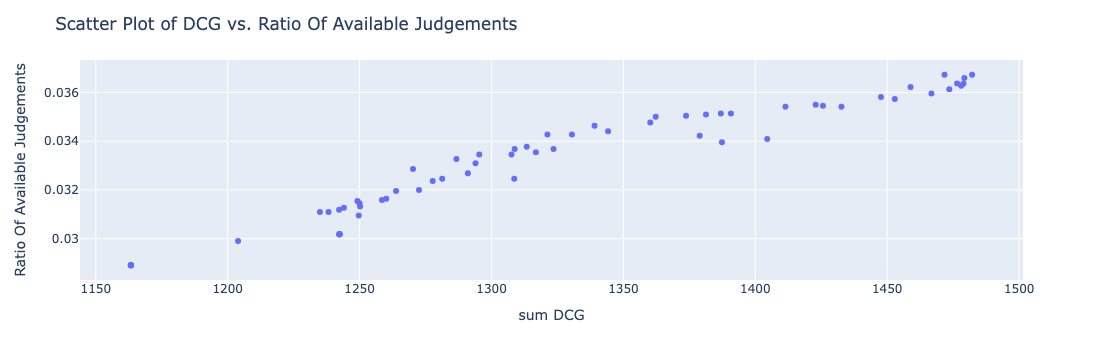

In [89]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_qd_metrics[df_qd_metrics.metric=="sum_dcg"], 
                 x='value', y='ratio', 
                 hover_data={'pipeline': True},  # Show query on hover
                 labels={'value': 'DCG', 'ratio': 'Ratio Of Available Judgements'})

# Customize the layout
fig.update_layout(title="Scatter Plot of DCG vs. Ratio Of Available Judgements",
                  xaxis_title="sum DCG",
                  yaxis_title="Ratio Of Available Judgements",
                  hovermode="closest")

# Show the plot
fig.show()

In [77]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_qd_metrics[df_qd_metrics.metric=="mean_dcg"], 
                 x='value', y='ratio', 
                 hover_data={'pipeline': True},  # Show query on hover
                 labels={'value': 'DCG', 'ratio': 'Ratio Of Available Judgements'})

# Customize the layout
fig.update_layout(title="Scatter Plot of DCG vs. Ratio Of Available Judgements",
                  xaxis_title="mean DCG",
                  yaxis_title="Ratio Of Available Judgements",
                  yaxis=dict(range=[0.2, 0.4]),
                  hovermode="closest")

# Show the plot
fig.show()

## Visualization of DCG values comparing the two approaches

Merge the DFs and visualize the DCG values in a scattertplot

In [78]:
df_qd_metrics.head(3)

,pipeline,metric,value,judgements,mising,ratio
0,min_maxarithmetic_mean0.0,sum_dcg,1163.316628,636,20293,0.028909
0,min_maxarithmetic_mean0.0,mean_dcg,1.829114,636,20293,0.028909
0,min_maxarithmetic_mean0.1,sum_dcg,1203.937049,658,20044,0.029909


In [79]:
df_metrics_per_pipeline.head(3)

metric,pipeline,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
0,l2arithmetic_mean0.0,5.29,11.67,0.24,0.28,0.29
1,l2arithmetic_mean0.1,6.31,11.77,0.29,0.33,0.34
2,l2arithmetic_mean0.2,6.38,11.89,0.29,0.33,0.34


In [80]:
df_metrics_merged = df_qd_metrics[df_qd_metrics.metric=="sum_dcg"].merge(df_metrics_per_pipeline, on='pipeline', how='inner', validate='one_to_one')

In [81]:
df_metrics_merged.head(3)

,pipeline,metric,value,judgements,mising,ratio,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
0,min_maxarithmetic_mean0.0,sum_dcg,1163.316628,636,20293,0.028909,5.29,11.67,0.24,0.28,0.29
1,min_maxarithmetic_mean0.1,sum_dcg,1203.937049,658,20044,0.029909,5.47,12.62,0.25,0.29,0.30
2,min_maxarithmetic_mean0.2,sum_dcg,1249.670778,681,20037,0.030955,5.68,12.62,0.26,0.30,0.31


In [82]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_metrics_merged, 
                 x='dcg', y='value', 
                 hover_data={'pipeline': True},  # Show query on hover
                 labels={'dcg': 'averaging over query DCGs', 'value': 'sum of query-doc DCGs'})

# Customize the layout
fig.update_layout(title="Scatter Plot of different DCG calculations",
                  xaxis_title="DCG - averaging over query DCGs",
                  yaxis_title="DCG - sum of query-doc DCGs",
                  hovermode="closest")

# Show the plot
fig.show()

In [83]:
df_metrics_merged.sort_values(by='value', ascending=False).head(5)

,pipeline,metric,value,judgements,mising,ratio,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
37,l2arithmetic_mean0.4,sum_dcg,1482.169436,808,20124,0.036727,6.74,12.55,0.31,0.35,0.37
38,l2arithmetic_mean0.5,sum_dcg,1479.240959,805,20030,0.036591,6.72,12.74,0.30,0.35,0.37
6,min_maxarithmetic_mean0.6,sum_dcg,1478.913637,800,20027,0.036364,6.72,12.61,0.30,0.35,0.36
36,l2arithmetic_mean0.3,sum_dcg,1478.069707,798,20204,0.036273,6.72,12.39,0.30,0.35,0.36
39,l2arithmetic_mean0.6,sum_dcg,1476.480500,800,20031,0.036364,6.71,12.60,0.30,0.35,0.36


In [84]:
df_metrics_merged.sort_values(by='dcg', ascending=False).head(5)

,pipeline,metric,value,judgements,mising,ratio,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
37,l2arithmetic_mean0.4,sum_dcg,1482.169436,808,20124,0.036727,6.74,12.55,0.31,0.35,0.37
36,l2arithmetic_mean0.3,sum_dcg,1478.069707,798,20204,0.036273,6.72,12.39,0.30,0.35,0.36
6,min_maxarithmetic_mean0.6,sum_dcg,1478.913637,800,20027,0.036364,6.72,12.61,0.30,0.35,0.36
38,l2arithmetic_mean0.5,sum_dcg,1479.240959,805,20030,0.036591,6.72,12.74,0.30,0.35,0.37
39,l2arithmetic_mean0.6,sum_dcg,1476.480500,800,20031,0.036364,6.71,12.60,0.30,0.35,0.36


In [85]:
df_mean_dcg_merged = df_qd_metrics[df_qd_metrics.metric=="mean_dcg"].merge(df_metrics_per_pipeline, on='pipeline', how='inner', validate='one_to_one')

In [86]:
df_mean_dcg_merged.head(3)

,pipeline,metric,value,judgements,mising,ratio,dcg,dcg_dense,ndcg,prec@10,ratio_of_ratings
0,min_maxarithmetic_mean0.0,mean_dcg,1.829114,636,20293,0.028909,5.29,11.67,0.24,0.28,0.29
1,min_maxarithmetic_mean0.1,mean_dcg,1.829692,658,20044,0.029909,5.47,12.62,0.25,0.29,0.30
2,min_maxarithmetic_mean0.2,mean_dcg,1.835053,681,20037,0.030955,5.68,12.62,0.26,0.30,0.31


In [87]:
pio.renderers.default = 'plotly_mimetype'
fig = px.scatter(df_mean_dcg_merged, 
                 x='dcg', y='value', 
                 hover_data={'pipeline': True},  # Show query on hover
                 labels={'dcg': 'averaging over query DCGs', 'value': 'mean over query-doc DCGs'})

# Customize the layout
fig.update_layout(title="Scatter Plot of different DCG calculations",
                  xaxis_title="DCG - averaging over query DCGs",
                  yaxis_title="DCG - mean over query-doc DCGs",
                  hovermode="closest")

# Show the plot
fig.show()

# Alexey: I didn't review the part below

## Find Query Set with most judgements in the ESCI dataset

To minimize the uncertainty we may have when calculating metrics over result sets that have a large ratio of missing judgements we choose those queries in the dataset that have the most judgements

In [88]:
DATA_DIR = '/Users/danielwrigley/work/Testing/git_repos/esci-data/shopping_queries_dataset/'

In [40]:
df_judgements = pd.read_parquet(DATA_DIR + '/shopping_queries_dataset_examples.parquet')

In [120]:
df_judgements.head(3)

,example_id,query,query_id,product_id,product_locale,esci_label,small_version,large_version,split
0,0,revent 80 cfm,0,B000MOO21W,us,I,0,1,train
1,1,revent 80 cfm,0,B07X3Y6B1V,us,E,0,1,train
2,2,revent 80 cfm,0,B07WDM7MQQ,us,E,0,1,train


In [121]:
df_grouped = df_judgements[df_judgements['product_locale'] == 'us'].groupby(by='query').size().reset_index(name='count')

In [122]:
df_grouped.sort_values(by='count', ascending=False).head(250)

,query,count
88554,tv,198
6208,airpods,188
49915,laptop,167
77206,shoes,158
69482,printer,136
...,...,...
22370,coffee filters,56
45348,iphone connector adapter,56
25122,curtains,56
32581,fat burners for women,56


In [123]:
query_set_id = "most_judged"
df_most_judged = df_grouped.sort_values(by='count', ascending=False).head(250)
df_most_judged = df_most_judged.drop(columns=['count'])
df_most_judged["query_set_id"] = query_set_id
df_most_judged.reset_index(drop=True, inplace=True)

In [124]:
df_most_judged.head(5)

,query,query_set_id
0,tv,most_judged
1,airpods,most_judged
2,laptop,most_judged
3,shoes,most_judged
4,printer,most_judged


In [125]:
df_most_judged.to_csv('most_judged.csv', index=False)

In [135]:
df_metrics

,pipeline,metric,value,judgements,mising,ratio
0,min_maxarithmetic_mean0.0,dcg,13.700970,621,1579,0.282273
1,min_maxarithmetic_mean0.1,dcg,14.797880,690,1510,0.313636
2,min_maxarithmetic_mean0.2,dcg,16.647365,710,1490,0.322727
3,min_maxarithmetic_mean0.3,dcg,16.647365,722,1478,0.328182
4,min_maxarithmetic_mean0.4,dcg,16.515894,730,1470,0.331818
...,...,...,...,...,...,...
61,l2geometric_mean0.6,dcg,15.351486,723,1477,0.328636
62,l2geometric_mean0.7,dcg,15.351486,721,1479,0.327727
63,l2geometric_mean0.8,dcg,15.351486,722,1478,0.328182
64,l2geometric_mean0.9,dcg,14.244275,719,1481,0.326818
